In [192]:
import pandas as pd
pd.set_option("mode.copy_on_write", True)
import geopandas as gpd
import fiona


In [193]:
# Step 1: Load FRAP Perimeter Data

# Path to the `.gdb` folder (NOT a file inside it)
fire_path = "/Users/nzaramakouadio/Documents/Duke Classes/Spring 2025/ML/IDS705_MachineLearning_Project/Downloaded_Data/fire_perimeter_data.gdb" # download and store it

# List all available layers in the geodatabase
layers = fiona.listlayers(fire_path)
print(layers)  # You'll see something like ['firep20_1', 'rxburn21', etc.]

# Load one of the layers (try first layer if unsure)
fire_perimeter_data = gpd.read_file(fire_path, layer=layers[0])

# Clean for the merge: remove extra space
fire_perimeter_data["FIRE_NAME_CLEAN"] = fire_perimeter_data["FIRE_NAME"].str.upper().str.strip()
fire_perimeter_data = fire_perimeter_data.drop(columns=["FIRE_NAME"]) # drop original column to avoid confusion

# View first few rows
fire_perimeter_data.head(4)

['firep23_1', 'rxburn23_1']


,YEAR_,STATE,AGENCY,UNIT_ID,INC_NUM,IRWINID,ALARM_DATE,CONT_DATE,C_METHOD,CAUSE,OBJECTIVE,GIS_ACRES,COMPLEX_NAME,COMPLEX_ID,COMMENTS,FIRE_NUM,Shape_Length,Shape_Area,geometry,FIRE_NAME_CLEAN
0,2023.0,CA,CDF,SKU,00004808,{7985848C-0AC2-4BA4-8F0E-29F778652E61},2023/06/17 00:00:00+00,2023/06/17 00:00:00+00,1.0,5.0,1.0,5.729125,None,None,None,None,933.907127,23184.946763,"MULTIPOLYGON (((-243242.555 394267.371, -24324...",WHITWORTH
1,2023.0,CA,LRA,BTU,00010225,{43EBCC88-B3AC-48EB-8EF5-417FE0939CCF},2023/06/02 00:00:00+00,2023/06/02 00:00:00+00,1.0,5.0,1.0,13.602385,None,None,None,None,986.343353,55046.898792,"MULTIPOLYGON (((-167826.147 203275.612, -16782...",KAISER
2,2023.0,CA,CDF,AEU,00017640,{B64E1355-BF1D-441A-95D0-BC1FBB93483B},2023/07/01 00:00:00+00,2023/07/02 00:00:00+00,1.0,2.0,1.0,27.814465,None,None,None,None,2115.572740,112561.147688,"MULTIPOLYGON (((-79176.443 31393.49, -78959.04...",JACKSON
3,2023.0,CA,CDF,AEU,00018821,{CB41DB0A-E4B1-489D-A4EA-738F2CD6DB3B},2023/07/11 00:00:00+00,2023/07/11 00:00:00+00,1.0,9.0,1.0,58.760227,None,None,None,None,1994.866526,237794.210367,"MULTIPOLYGON (((-85936.934 47921.886, -85856.4...",CARBON


In [194]:
print(fire_perimeter_data["YEAR_"].value_counts().sort_values())


YEAR_
1878.0      1
1905.0      1
1895.0      1
1896.0      1
1902.0      1
         ... 
2021.0    388
2018.0    416
2008.0    439
2020.0    505
2017.0    608
Name: count, Length: 126, dtype: int64


In [195]:
fire_perimeter_data.isna().sum()

YEAR_                 77
STATE                  0
AGENCY                53
UNIT_ID               64
INC_NUM              695
IRWINID            18965
ALARM_DATE          5396
CONT_DATE          12629
C_METHOD           12121
CAUSE                 24
OBJECTIVE            247
GIS_ACRES              0
COMPLEX_NAME       21653
COMPLEX_ID         21901
COMMENTS            2227
FIRE_NUM            4618
Shape_Length           0
Shape_Area             0
geometry               0
FIRE_NAME_CLEAN       62
dtype: int64

In [196]:
fire_perimeter_data.shape

(22261, 20)

In [197]:
# Step 2: Load CAL FIRE Incident Archive

# Read the file
cal_fire_path = "https://incidents.fire.ca.gov/imapdata/mapdataall.csv" # taken from the website
calfire_incidents_data = pd.read_csv(cal_fire_path)


In [198]:
calfire_incidents_data.isna().sum()

incident_name                          0
incident_is_final                      0
incident_date_last_update              0
incident_date_created                  0
incident_administrative_unit          60
incident_administrative_unit_url    2858
incident_county                       10
incident_location                      0
incident_acres_burned                 53
incident_containment                  57
incident_control                    2741
incident_cooperating_agencies       1196
incident_longitude                     0
incident_latitude                      0
incident_type                       1234
incident_id                            0
incident_url                           0
incident_date_extinguished           633
incident_dateonly_extinguished       633
incident_dateonly_created              0
is_active                              0
calfire_incident                       0
notification_desired                   0
dtype: int64

In [199]:
calfire_incidents_data.shape

(2858, 23)

In [200]:
# Step 2: Load CAL FIRE Incident Archive

# Read the file
cal_fire_path = "https://incidents.fire.ca.gov/imapdata/mapdataall.csv" # taken from the website
calfire_incidents_data = pd.read_csv(cal_fire_path)

print(calfire_incidents_data.columns)

# Susbset only useful columns
useful_cols = [
    "incident_name", "incident_date_created", "incident_county",
    "incident_acres_burned", "incident_type", "incident_date_extinguished"
]

calfire_filtered = calfire_incidents_data[useful_cols]

# Clean up for merge: remove "fire" in names so we can match by fire name
calfire_filtered["incident_name_clean"] = (
    calfire_filtered["incident_name"]
    .str.upper()
    .str.replace(" FIRE", "", regex=False)
    .str.strip()
)
calfire_filtered = calfire_filtered.drop(columns=["incident_name"]) # drop original column to avoid confusion

# Clean up for merge: Extract the year from the start date so we can merge by year
calfire_filtered["YEAR_"] = pd.to_datetime(
    calfire_filtered["incident_date_created"]
).dt.year

calfire_filtered = calfire_filtered.drop(columns=["incident_date_created"]) # drop original column to avoid confusion

# Some fires where entered multiple times with different acres burned: select the one with higher acre burned
calfire_filtered = (
    calfire_filtered.sort_values("incident_acres_burned", ascending=False)
    .drop_duplicates(subset=["incident_name_clean", "YEAR_"], keep="first")
)

calfire_filtered.head(5)


Index(['incident_name', 'incident_is_final', 'incident_date_last_update',
       'incident_date_created', 'incident_administrative_unit',
       'incident_administrative_unit_url', 'incident_county',
       'incident_location', 'incident_acres_burned', 'incident_containment',
       'incident_control', 'incident_cooperating_agencies',
       'incident_longitude', 'incident_latitude', 'incident_type',
       'incident_id', 'incident_url', 'incident_date_extinguished',
       'incident_dateonly_extinguished', 'incident_dateonly_created',
       'is_active', 'calfire_incident', 'notification_desired'],
      dtype='object')


,incident_county,incident_acres_burned,incident_type,incident_date_extinguished,incident_name_clean,YEAR_
1653,"Mendocino, Humboldt, Trinity, Tehama, Glenn, L...",1032648.0,Wildfire,2020-11-11T10:21:44Z,AUGUST COMPLEX (INCLUDES DOE),2020
1841,"Butte, Plumas, Shasta, Lassen, Tehama",963309.0,Wildfire,2021-10-25T07:45:46Z,DIXIE,2021
2552,"Butte, Tehama",429603.0,Wildfire,NaN,PARK,2024
1099,"Colusa, Mendocino, Glenn, Lake",410203.0,Wildfire,2019-01-04T09:33:00Z,RANCH (MENDOCINO COMPLEX),2018
1660,"Santa Clara, San Joaquin, Contra Costa, Alamed...",396624.0,Wildfire,2020-10-01T10:29:00Z,SCU LIGHTNING COMPLEX,2020


In [201]:
calfire_filtered["YEAR_"].value_counts().sort_values() # we have so many years missing of metadata

YEAR_
2009      1
1969      2
2025     50
2014     75
2015     97
2023    129
2013    134
2016    145
2022    145
2021    171
2019    235
2020    236
2018    277
2017    375
2024    525
Name: count, dtype: int64

In [202]:
calfire_filtered.isna().sum()

incident_county                 10
incident_acres_burned           47
incident_type                 1124
incident_date_extinguished     562
incident_name_clean              0
YEAR_                            0
dtype: int64

In [203]:
# Step 3: Filter both dataset to only take data from 2012 to 2023
# Do this cause one the years do not match

# Define year range
min_year = 2012
max_year = 2023

# Filter both datasets
fire_perimeter_filtered = fire_perimeter_data[
    fire_perimeter_data["YEAR_"].between(min_year, max_year)
]

calfire_filtered = calfire_filtered[
    calfire_filtered["YEAR_"].between(min_year, max_year)
]


In [204]:
fire_perimeter_filtered.shape

(4389, 20)

In [205]:
calfire_filtered.shape

(2019, 6)

In [206]:
#fire_perimeter_filtered["YEAR_"].value_counts()

In [207]:
#calfire_filtered["YEAR_"].value_counts()

In [208]:
# Step 4: Merge FRAP + CAL FIRE
merged_fire_data = fire_perimeter_filtered.merge(
    calfire_filtered,
    left_on=["FIRE_NAME_CLEAN", "YEAR_"],
    right_on=["incident_name_clean", "YEAR_"],
    how="left", # ← left table is fire_perimeter
    indicator = True
)

# Check if merge was successfully done
# left_only = rows from FRAP (fire perimeter) that did not find a match
# both = rows from FRAP that did find a match with CAL FIRE
# right_only = rows from CAL FIRE that were not used in the merge
# Since right_only == 0, it means every row in calfire_filtered was matched to at least one FRAP row.

print(merged_fire_data["_merge"].value_counts())

# Check how many rows successfully got metadata
print("Match rate:", merged_fire_data["incident_county"].notna().mean())
# Note: Our match rate is not a sign of something broken — it's just a limitation of the available metadatan from cali_fire_data.


_merge
left_only     2829
both          1560
right_only       0
Name: count, dtype: int64
Match rate: 0.3547505126452495


In [209]:
print(merged_fire_data.shape[0] == fire_perimeter_filtered.shape[0])
print(merged_fire_data.shape[0])
print(fire_perimeter_filtered.shape[0])


True
4389
4389


In [210]:
# Step 4: Load ZIP Code Shapefile

# Path to the folder containing the shapefile components
zip_path = "/Users/nzaramakouadio/Documents/Duke Classes/Spring 2025/ML/IDS705_MachineLearning_Project/Downloaded_Data/Cali_Zip_Codes/California_Zip_Codes.shp"

# Load the shapefile as a GeoDataFrame
zip_cali = gpd.read_file(zip_path)
# Quick look
zip_cali.head(10)

/opt/miniconda3/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/nzaramakouadio/Documents/Duke Classes/Spring 2025/ML/IDS705_MachineLearning_Project/Downloaded_Data/Cali_Zip_Codes/California_Zip_Codes.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


,ZIP_CODE,PO_NAME,STATE,POPULATION,POP_SQMI,SQMI,geometry
0,00012,Mt Meadows Area,CA,-99,-99.0,30.92,"POLYGON ((-235397.856 9938636.426, -235571.593..."
1,00016,Sequoia National Forest,CA,-99,-99.0,39.33,"POLYGON ((463415.33 8230735.164, 450342.706 82..."
2,00017,Northeast Fresno County,CA,-99,-99.0,564.38,"POLYGON ((354976.178 8923823.768, 354863.088 8..."
3,00018,Los Padres Ntl Forest,CA,-99,-99.0,90.83,"POLYGON ((355769.015 7866496.399, 348656.291 7..."
4,00019,Lassen Ntl Forest,CA,-99,-99.0,412.59,"POLYGON ((384.567 10127749.312, 294.796 101278..."
5,00020,Sierra National Forest,CA,-99,-99.0,397.92,"POLYGON ((211062.432 9023070.605, 210945.532 9..."
6,00022,Jackson St Forest,CA,-99,-99.0,11.02,"POLYGON ((-1004588.335 9629573.879, -1004390.2..."
7,00026,East Tulare County,CA,-99,-99.0,1456.21,"POLYGON ((479587.97 8663731.36, 465721.827 866..."
8,00028,Plumas Ntl Forest,CA,-99,-99.0,113.83,"POLYGON ((-126674.336 9916664.478, -126660.202..."
9,00029,Tahoe National Forest,CA,-99,-99.0,2.17,"POLYGON ((-296973.074 9674126.214, -297126.307..."


In [211]:
# Step 5: Spatial Join – ZIP Codes + Fires

''' We performe a spatial join to link each fire incident to a ZIP code region,
using their geometries. This allows us to analyze the impact of wildfires by ZIP.'''

# Make sure both GeoDataFrames use the same CRS
# CRS tells your GeoDataFrame how to interpret the geometry numbers
merged_fire_data = merged_fire_data.to_crs(zip_cali.crs)

# Spatial join: attach ZIP info to each fire based on location
#fires_with_zip = gpd.sjoin(merged_fire_data, zip_cali, how="left", predicate="intersects")
# Advanced but precise step
fires_with_zip = gpd.overlay(merged_fire_data, zip_cali, how="intersection")

fires_with_zip.head(5)
# Preview result
#fires_with_zip[["FIRE_NAME_CLEAN", "YEAR_", "ZIP_CODE", "PO_NAME", "geometry"]].head()



,YEAR_,STATE_1,AGENCY,UNIT_ID,INC_NUM,IRWINID,ALARM_DATE,CONT_DATE,C_METHOD,CAUSE,...,incident_date_extinguished,incident_name_clean,_merge,ZIP_CODE,PO_NAME,STATE_2,POPULATION,POP_SQMI,SQMI,geometry
0,2023.0,CA,CDF,SKU,00004808,{7985848C-0AC2-4BA4-8F0E-29F778652E61},2023/06/17 00:00:00+00,2023/06/17 00:00:00+00,1.0,5.0,...,NaN,NaN,left_only,96027,Etna,CA,2306,9.63,239.45,"POLYGON ((-798045.31 10416856.729, -798049.369..."
1,2023.0,CA,LRA,BTU,00010225,{43EBCC88-B3AC-48EB-8EF5-417FE0939CCF},2023/06/02 00:00:00+00,2023/06/02 00:00:00+00,1.0,5.0,...,NaN,NaN,left_only,95973,Chico,CA,35359,144.35,244.96,"POLYGON ((-550608.931 9790227.653, -550633.684..."
2,2023.0,CA,CDF,AEU,00017640,{B64E1355-BF1D-441A-95D0-BC1FBB93483B},2023/07/01 00:00:00+00,2023/07/02 00:00:00+00,1.0,2.0,...,NaN,NaN,left_only,95640,Ione,CA,11147,85.53,130.33,"POLYGON ((-259051.453 9226881.32, -259013.035 ..."
3,2023.0,CA,CDF,AEU,00018821,{CB41DB0A-E4B1-489D-A4EA-738F2CD6DB3B},2023/07/11 00:00:00+00,2023/07/11 00:00:00+00,1.0,9.0,...,NaN,CARBON,both,95640,Ione,CA,11147,85.53,130.33,"POLYGON ((-281680.782 9280739.071, -281633.231..."
4,2023.0,CA,CDF,AEU,00018876,{F83F70A4-07A7-40B8-BD51-10CCC1C30D63},2023/07/11 00:00:00+00,2023/07/12 00:00:00+00,1.0,14.0,...,NaN,LIBERTY,both,95640,Ione,CA,11147,85.53,130.33,"POLYGON ((-283582.48 9210015.961, -283653.076 ..."


In [212]:
fires_with_zip.columns

Index(['YEAR_', 'STATE_1', 'AGENCY', 'UNIT_ID', 'INC_NUM', 'IRWINID',
       'ALARM_DATE', 'CONT_DATE', 'C_METHOD', 'CAUSE', 'OBJECTIVE',
       'GIS_ACRES', 'COMPLEX_NAME', 'COMPLEX_ID', 'COMMENTS', 'FIRE_NUM',
       'Shape_Length', 'Shape_Area', 'FIRE_NAME_CLEAN', 'incident_county',
       'incident_acres_burned', 'incident_type', 'incident_date_extinguished',
       'incident_name_clean', '_merge', 'ZIP_CODE', 'PO_NAME', 'STATE_2',
       'POPULATION', 'POP_SQMI', 'SQMI', 'geometry'],
      dtype='object')

In [213]:
zip_code_match_rate = 1 - fires_with_zip["ZIP_CODE"].isna().mean()
zip_code_match_rate 

# Result: 97.3% of fire records successfully matched with a ZIP code — which is excellent.
# This high match rate confirms that most fires occurred within mailable ZIP boundaries,
# and our CRS alignment + geometry processing was done correctly.


1.0

In [214]:
# Drop the fires with no zip codes match
fires_with_zip = fires_with_zip[~fires_with_zip["ZIP_CODE"].isna()]

# Check if it worked
#zip_code_match_rate = 1 - fires_with_zip["ZIP_CODE"].isna().mean()
#zip_code_match_rate 

In [215]:
# Step 6: Remove all unecessary columns
fires_with_zip.columns

columns_to_keep = [
    "YEAR_", 
    "FIRE_NAME_CLEAN", 
    "ZIP_CODE",
    "incident_county", 
    "PO_NAME", # Name of Post Office for ZIP ==> Contextual ZIP label (can keep for readability)
    "ALARM_DATE", # Start date of the fire
    "CONT_DATE", # Date fire was controled
    "GIS_ACRES", # The total area burned by the wildfire — across all areas, not just within a single ZIP code.
    "CAUSE", # What started the fire
    "SQMI", # Area of the ZIP in square miles — good for calculating % burned if needed
    "PO_NAME", # Name of Post Office for ZIP ==> Contextual ZIP label (can keep for readability)
    "POPULATION",
    "POP_SQMI", # Population density ==> can be useful for exposure modeling
    "geometry" # shape of the fire: Required for future spatial analysis
]


fires_cleaned = fires_with_zip[columns_to_keep]
fires_cleaned.head(4)



,YEAR_,FIRE_NAME_CLEAN,ZIP_CODE,incident_county,PO_NAME,ALARM_DATE,CONT_DATE,GIS_ACRES,CAUSE,SQMI,PO_NAME,POPULATION,POP_SQMI,geometry
0,2023.0,WHITWORTH,96027,NaN,Etna,2023/06/17 00:00:00+00,2023/06/17 00:00:00+00,5.729125,5.0,239.45,Etna,2306,9.63,"POLYGON ((-798045.31 10416856.729, -798049.369..."
1,2023.0,KAISER,95973,NaN,Chico,2023/06/02 00:00:00+00,2023/06/02 00:00:00+00,13.602385,5.0,244.96,Chico,35359,144.35,"POLYGON ((-550608.931 9790227.653, -550633.684..."
2,2023.0,JACKSON,95640,NaN,Ione,2023/07/01 00:00:00+00,2023/07/02 00:00:00+00,27.814465,2.0,130.33,Ione,11147,85.53,"POLYGON ((-259051.453 9226881.32, -259013.035 ..."
3,2023.0,CARBON,95640,Amador,Ione,2023/07/11 00:00:00+00,2023/07/11 00:00:00+00,58.760227,9.0,130.33,Ione,11147,85.53,"POLYGON ((-281680.782 9280739.071, -281633.231..."


In [216]:
# Step 6: Feature engineering

'''Our goal is to create variables that better show the impact/severity of the fire'''

################################## Create duration variable of each fire ########################
# Ensure the dates are in datetime format
fires_cleaned["ALARM_DATE"] = pd.to_datetime(fires_cleaned["ALARM_DATE"], errors="coerce")
fires_cleaned["CONT_DATE"] = pd.to_datetime(fires_cleaned["CONT_DATE"], errors="coerce")

# Create a new column for fire duration in days
fires_cleaned["FIRE_DURATION_DAYS"] = (fires_cleaned["CONT_DATE"] - fires_cleaned["ALARM_DATE"]).dt.days
fires_cleaned["FIRE_DURATION_DAYS"].value_counts() # some values are negative

# Remove any that is negetaive
# Count how many rows have FIRE_DURATION_DAYS < 0
negative_durations = (fires_cleaned["FIRE_DURATION_DAYS"] < 0).sum()
#print(f"Number of negative durations: {negative_durations}") # there's 5, I'll assume it was a mistake

# Keep only rows where FIRE_DURATION_DAYS is greater than 0
fires_cleaned = fires_cleaned[fires_cleaned["FIRE_DURATION_DAYS"] > 0]


# Results: 
# 0 days: ~1,862 fires started and were contained on the same day (controlled burns, quick response, or very minor incidents).
# 1–4 days: Hundreds of fires — very typical for short-lived wildfires.
# >100 days: Only a few — likely major wildfires or cases with delayed containment/reporting.

In [217]:
##################################### Percetange of acres burned for each fire  ###################

# Reproject to an equal-area CRS (EPSG:5070 = NAD83 / Conus Albers)
fires_cleaned = fires_cleaned.to_crs(epsg=5070)

# Step 1: Calculate the intersection area in square meters
# Geometric area where a fire and a ZIP code intersected
fires_cleaned["INTERSECT_SQ_M"] = fires_cleaned.geometry.area

# Step 2: Convert intersection area to acres (1 sq meter = 0.000247105 acres)
# Area of the fire that overlaps with the ZIP code
# The portion of the fire that falls within the boundaries of this specific ZIP code.
fires_cleaned["INTERSECT_ACRES"] = fires_cleaned["INTERSECT_SQ_M"] * 0.000247105

# Step 3: Create ZIP_ACRES from SQMI (1 square mile = 640 acres)
# Total area of the zip code is acres instaed of miles (using SQMI)
fires_cleaned["ZIP_ACRES"] = fires_cleaned["SQMI"] * 640

# Step 4: Calculate percentage of ZIP code burned
#Percent of the ZIP code area that was burned (based on intersection with fire area)
fires_cleaned["PCT_ZIP_BURNED"] = (
    fires_cleaned["INTERSECT_ACRES"] / fires_cleaned["ZIP_ACRES"]
) * 100

# Preview result
fires_cleaned.head(3)

### Important:
# The fire’s area is “redistributed” to the ZIP codes it intersects.
# That’s why in our final dataset, the same fire can show up in multiple rows, each with a different ZIP code and different INTERSECT_ACRES depending on how much it burned there.



,YEAR_,FIRE_NAME_CLEAN,ZIP_CODE,incident_county,PO_NAME,ALARM_DATE,CONT_DATE,GIS_ACRES,CAUSE,SQMI,PO_NAME,POPULATION,POP_SQMI,geometry,FIRE_DURATION_DAYS,INTERSECT_SQ_M,INTERSECT_ACRES,ZIP_ACRES,PCT_ZIP_BURNED
2,2023.0,JACKSON,95640,NaN,Ione,2023-07-01 00:00:00+00:00,2023-07-02 00:00:00+00:00,27.814465,2.0,130.33,Ione,11147,85.53,"POLYGON ((-2132849.501 1977174.61, -2132839.86...",1.0,1.125611e+05,27.814423,83411.2,0.033346
4,2023.0,LIBERTY,95640,Amador,Ione,2023-07-11 00:00:00+00:00,2023-07-12 00:00:00+00:00,70.978996,14.0,130.33,Ione,11147,85.53,"POLYGON ((-2141326.037 1974007.565, -2141354.3...",1.0,2.872418e+05,70.978888,83411.2,0.085095
7,2023.0,VINEYARD,93451,"Monterey, San Luis Obispo",San Miguel,2023-07-09 00:00:00+00:00,2023-07-10 00:00:00+00:00,391.374939,14.0,445.65,San Miguel,4355,9.77,"POLYGON ((-2187795.957 1702957.327, -2187791.4...",1.0,1.583838e+06,391.374347,285216.0,0.137220


In [218]:
# Optional check: The same fire appears in multiple ZIPs. The INTERSECT_ACRES values vary by ZIP. The sum adds up to GIS_ACRES.

#  ~97% of the land area of ZIP code 95969 was within the Camp Fire burn perimeter, which really happened so it's correctly done.
#fires_cleaned[fires_cleaned["FIRE_NAME_CLEAN"] == "CAMP"]

In [219]:
# Final fire dataset

final_fire_data = fires_cleaned.groupby(["ZIP_CODE", "YEAR_"]).agg(
    NUM_FIRES = ("FIRE_NAME_CLEAN", "nunique"), # total number of fires for that zipcode in a year
    TOTAL_ACRES_BURNED_IN_ZIP = ("INTERSECT_ACRES", "sum"), # it represents how much land within that specific ZIP burned in a given year.
    AVG_FIRE_DURATION_DAYS = ("FIRE_DURATION_DAYS", "mean"), # average number of days that fires lasted in that ZIP code in that year.
    MAX_PCT_ZIP_BURNED = ("PCT_ZIP_BURNED", "max"),  # maximum percentage of the ZIP code’s land area that was burned by a single fire in that year
)

final_fire_data["ANY_MAJOR_FIRE"] = (final_fire_data["MAX_PCT_ZIP_BURNED"] > 5).astype(int) # 10% or higher means at least one-tenth of the ZIP code’s land burned in a single fire
final_fire_data.reset_index(inplace=True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


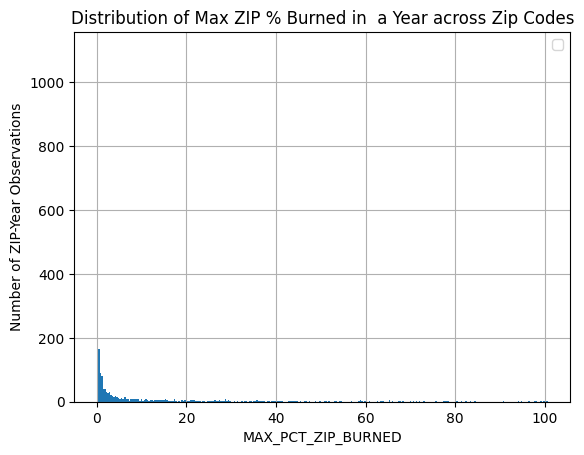

In [220]:
final_fire_data["MAX_PCT_ZIP_BURNED"].describe(percentiles=[.25, .5, .75, .9, .95])

import matplotlib.pyplot as plt
final_fire_data["MAX_PCT_ZIP_BURNED"].hist(bins=300)

plt.legend()
plt.title("Distribution of Max ZIP % Burned in  a Year across Zip Codes")
plt.xlabel("MAX_PCT_ZIP_BURNED")
plt.ylabel("Number of ZIP-Year Observations")
plt.show()


In [221]:
# Drop ZIPs starting with '000' since we are focusing on real residential ZIPs, those zip codes do NOT contain homes
final_fire_data = final_fire_data[~final_fire_data['ZIP_CODE'].str.startswith("000")] #Ignore unrecognizable ZIPs when reporting fire impact

final_fire_data = final_fire_data.sort_values(by="ZIP_CODE")

In [222]:
final_fire_data["MAX_PCT_ZIP_BURNED"].max()

100.71304542323074

In [223]:
print(final_fire_data.shape)
final_fire_data.head(10)

(2014, 7)


,ZIP_CODE,YEAR_,NUM_FIRES,TOTAL_ACRES_BURNED_IN_ZIP,AVG_FIRE_DURATION_DAYS,MAX_PCT_ZIP_BURNED,ANY_MAJOR_FIRE
133,90049,2012.0,1,39.644336,1.000000,0.412962,0
134,90049,2017.0,1,243.229969,9.000000,2.533646,0
135,90049,2019.0,1,552.632298,8.000000,5.756586,1
136,90068,2019.0,1,72.634180,1.000000,1.415099,0
137,90077,2012.0,1,13.878707,1.000000,0.291472,0
138,90077,2017.0,1,176.690177,9.000000,3.710731,0
139,90265,2013.0,1,1889.016043,9.000000,3.122382,0
140,90265,2016.0,1,11.325272,3.000000,0.018720,0
141,90265,2017.0,1,20.000522,3.000000,0.033059,0
142,90265,2018.0,3,40808.900063,4.666667,67.447315,1


In [224]:
final_fire_data.isna().sum()

ZIP_CODE                     0
YEAR_                        0
NUM_FIRES                    0
TOTAL_ACRES_BURNED_IN_ZIP    0
AVG_FIRE_DURATION_DAYS       0
MAX_PCT_ZIP_BURNED           0
ANY_MAJOR_FIRE               0
dtype: int64

In [226]:
final_fire_data.shape

(2014, 7)

In [ ]:
# Save cleaned fire data
final_fire_data.to_csv("final_fire_data.csv", index=False)